# Self-Organizing Maps (SOMs) Figure Notebook
- **Make composites from specified variable over all winters for a particular decade**
- Notebook by Alice DuVivier (NCAR)
- November 2022

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import seaborn as sns
import sammon
import dask
import utils

import cmocean


## Plot decadal winter means

In [28]:
# set the location of the already extracted training data
sector_short = 'Ross'
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/'+sector_short+'_analysis_v3/'
path_out = path_in+'figures_outline/'

In [3]:
# Set plotting limits
lat_max = -72
lat_min = -80
lon_max = 200
lon_min = 160
lon_avg = 190

### Specify variables to plot

In [4]:
# set path to the data
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'

# set what variables we can plot
var_composite_in = 'aice_d'

In [5]:
# file name for training variable only here 
fin_composite = 'antarctic_data_for_som_composites_'+var_composite_in

In [6]:
# load data
ds = xr.open_mfdataset(data_path_in+fin_composite+'.nc')

In [7]:
# explicitly load data so that it doesn't take forever later on during mean
ds = ds.load()

In [8]:
var_composite_in

'aice_d'

In [9]:
ds

<xarray.Dataset>
Dimensions:    (nj: 36, ni: 320, training_times: 232300)
Coordinates:
    time       (training_times) object 1980-07-01 00:00:00 ... 2080-09-30 00:...
    member_id  (training_times) object 'r1i1001p1f1' ... 'r9i1301p1f1'
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT       (nj, ni) float32 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
  * nj         (nj) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * ni         (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
Dimensions without coordinates: training_times
Data variables:
    data       (nj, ni, training_times) float32 nan nan nan ... 0.03121 0.05833
Attributes:
    Author:    Alice DuVivier
    units:     1
    longname:  ice area  (aggregate)

## Calculate the mean for all winter by decade

In [10]:
# calculate winter mean against which to do anomalies
mean_all = ds.data.mean(dim='training_times')

In [11]:
decade_names = ['1980','1990', '2000', '2010', '2020', '2030', '2040', '2050', '2060', '2070']

In [13]:
# make numpy array to fill and specify dimensions we want
decade_array = np.zeros([len(decade_names),len(mean_all.nj),len(mean_all.ni)])

for dd in decade_names:
    print('decade: '+dd+'s')
    if dd == '1980':
        d_count = 0
        yy_st = 1980
    else: 
        d_count = d_count+1
        yy_st = yy_st + 10
    # get years for this decade
    yy_ed = yy_st + 10
    yy_all = list(range(yy_st,yy_ed,1))
    # get mean for this decade
    decade_array[d_count,:,:] = ds.data.isel(training_times=ds.time.dt.year.isin([yy_all])).mean(dim='training_times')


decade: 1980s
decade: 1990s
decade: 2000s
decade: 2010s
decade: 2020s
decade: 2030s
decade: 2040s
decade: 2050s
decade: 2060s
decade: 2070s


In [14]:
print(decade_array.shape)

(10, 36, 320)


In [15]:
# convert the numpy array to a xarray for easier plotting
decade_means = xr.DataArray(decade_array,dims=('decade','nj','ni'))

In [16]:
# set coordinate arrays
decade_means['decade'] = decade_names
decade_means['nj'] = mean_all['nj'].values
decade_means['ni'] = mean_all['ni'].values

In [17]:
decade_means

<xarray.DataArray (decade: 10, nj: 36, ni: 320)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.99997157, 0.99994606, 0.99993086, ...,        nan,
                nan,        nan],
        ...,
        [0.78941661, 0.79325372, 0.79555827, ..., 0.76086533,
         0.77479821, 0.78417474],
        [0.67341667, 0.67865223, 0.68265015, ..., 0.63166803,
         0.65369081, 0.66695356],
        [0.51917404, 0.52487558, 0.53185487, ..., 0.46516696,
         0.49314246, 0.51123202]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.99997342, 0.99994797, 0.99993289, ...,        nan,
                nan,        nan],
...
        [0.30508134, 0.30683717, 0.30385473, ..., 0.27535191,
         0.28953046, 0.29994133],
        [0.16732118, 0.16742149, 0.16521485, ..., 0.14917967,
         0.15948755, 0.16543958],
        [0.0796138 , 0.07770807, 0.07568118, ..., 0.07123185,
         0.07774213, 0.08051462]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.99999523, 0.9999904 , 0.99998522, ...,        nan,
                nan,        nan],
        ...,
        [0.21407034, 0.21540068, 0.21252318, ..., 0.18744725,
         0.19990812, 0.20936109],
        [0.11024006, 0.11026309, 0.10817686, ..., 0.09420399,
         0.10283085, 0.10828974],
        [0.047531  , 0.046364  , 0.0449232 , ..., 0.04077852,
         0.04558304, 0.04786738]]])
Coordinates:
  * decade   (decade) <U4 '1980' '1990' '2000' '2010' ... '2050' '2060' '2070'
  * nj       (nj) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35
  * ni       (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

In [19]:
decade_means = decade_means*100

## Make plots

In [23]:
# set some labeling things
title = 'ice concentration' 
units = 'sea ice concentration (%)'
units_diff = 'change in sea ice concentration (%)'

levels_in = np.arange(70,102.5,2.5)
ticks_in = [70,80,90,100]
cmap_in = cmocean.cm.ice

levels_diff = np.arange(-25,27.5,2.5)
ticks_diff = [-20,-10,0,10,20]
cmap_diff = cmocean.cm.diff
cmap_diff = cmap_diff.reversed()

# set missing value color
grey_tone = 0.5

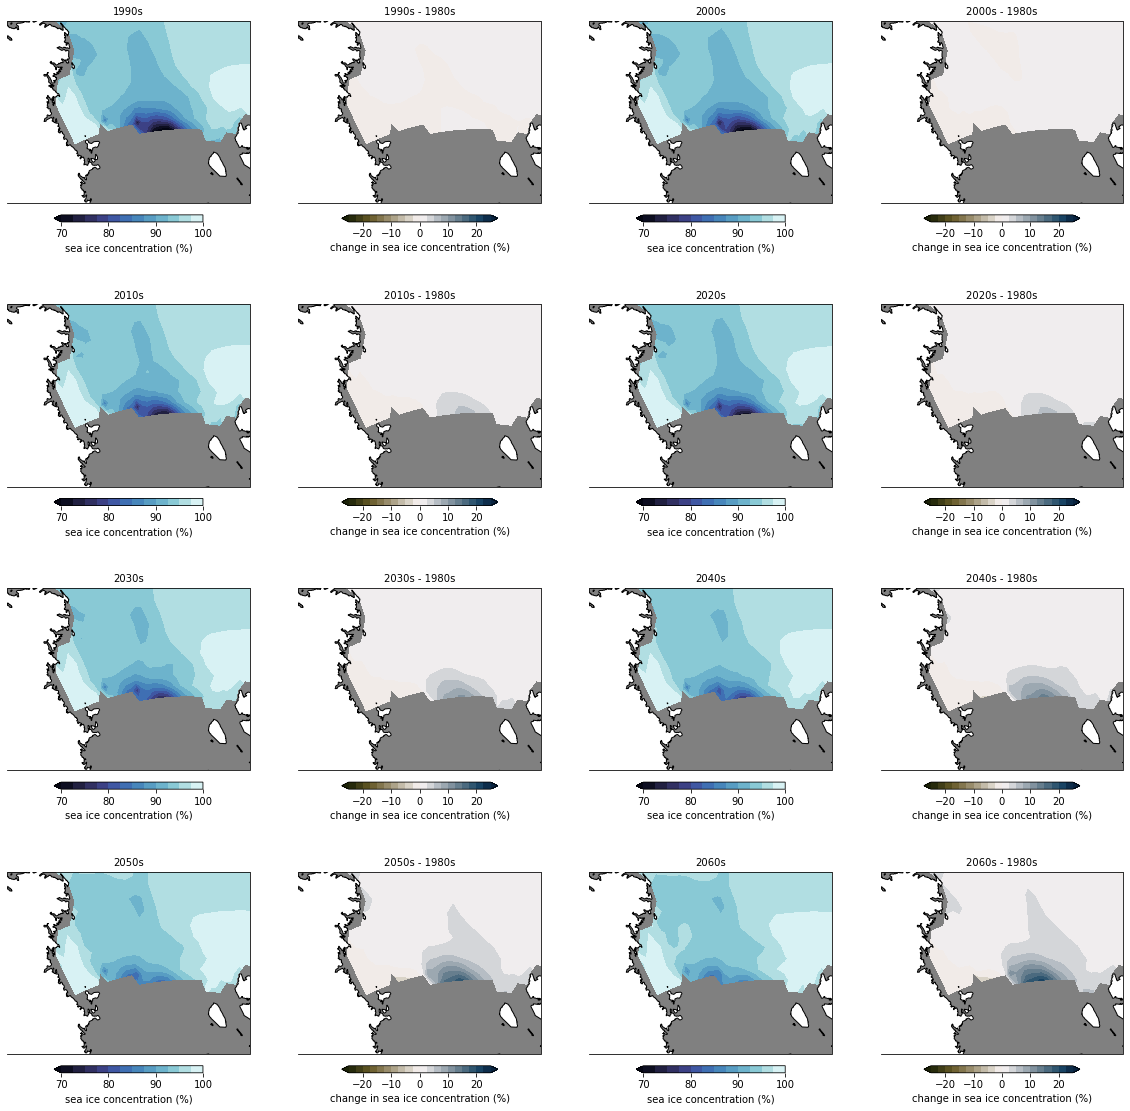

In [29]:
## supplementary figure - all decades
data_ctrl = decade_means.sel(decade='1980')

# create figure
fig = plt.figure(figsize=(20,20))
fout = path_out+'supp_fig1'

# get lats/lons for plotting
lons = ds.TLON
lats = ds.TLAT

# plot the subplots - note it's nrow x ncol x index (starting upper left)
### 1990
tag = '1990'
data_in = decade_means.sel(decade=tag)
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_in)
ax = fig.add_subplot(4,4,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_in,levels=levels_in,extend='min')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s',fontsize=10)

### diff
data_diff = data_in - data_ctrl
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_diff)
ax = fig.add_subplot(4,4,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_diff,levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units_diff,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s - 1980s',fontsize=10)

### 2000
tag = '2000'
data_in = decade_means.sel(decade=tag)
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_in)
ax = fig.add_subplot(4,4,3, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_in,levels=levels_in,extend='min')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s',fontsize=10)

### diff
data_diff = data_in - data_ctrl
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_diff)
ax = fig.add_subplot(4,4,4, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_diff,levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units_diff,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s - 1980s',fontsize=10)

### 2010
tag = '2010'
data_in = decade_means.sel(decade=tag)
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_in)
ax = fig.add_subplot(4,4,5, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_in,levels=levels_in,extend='min')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s',fontsize=10)

### diff
data_diff = data_in - data_ctrl
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_diff)
ax = fig.add_subplot(4,4,6, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_diff,levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units_diff,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s - 1980s',fontsize=10)

### 2020
tag = '2020'
data_in = decade_means.sel(decade=tag)
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_in)
ax = fig.add_subplot(4,4,7, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_in,levels=levels_in,extend='min')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s',fontsize=10)

### diff
data_diff = data_in - data_ctrl
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_diff)
ax = fig.add_subplot(4,4,8, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_diff,levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units_diff,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s - 1980s',fontsize=10)

### 2030
tag = '2030'
data_in = decade_means.sel(decade=tag)
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_in)
ax = fig.add_subplot(4,4,9, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_in,levels=levels_in,extend='min')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s',fontsize=10)

### diff
data_diff = data_in - data_ctrl
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_diff)
ax = fig.add_subplot(4,4,10, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_diff,levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units_diff,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s - 1980s',fontsize=10)

### 2040
tag = '2040'
data_in = decade_means.sel(decade=tag)
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_in)
ax = fig.add_subplot(4,4,11, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_in,levels=levels_in,extend='min')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s',fontsize=10)

### diff
data_diff = data_in - data_ctrl
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_diff)
ax = fig.add_subplot(4,4,12, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_diff,levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units_diff,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s - 1980s',fontsize=10)

### 2050
tag = '2050'
data_in = decade_means.sel(decade=tag)
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_in)
ax = fig.add_subplot(4,4,13, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_in,levels=levels_in,extend='min')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s',fontsize=10)

### diff
data_diff = data_in - data_ctrl
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_diff)
ax = fig.add_subplot(4,4,14, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_diff,levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units_diff,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s - 1980s',fontsize=10)

### 2060
tag = '2060'
data_in = decade_means.sel(decade=tag)
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_in)
ax = fig.add_subplot(4,4,15, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_in,levels=levels_in,extend='min')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s',fontsize=10)

### diff
data_diff = data_in - data_ctrl
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_diff)
ax = fig.add_subplot(4,4,16, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
this = ax.contourf(lon,lat,field,transform=ccrs.PlateCarree(),
                   cmap = cmap_diff,levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units_diff,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=10)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
plt.title(tag+'s - 1980s',fontsize=10)


# Finalize figure and save
fig.subplots_adjust(hspace=0.2)
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)

In [30]:
fout

'/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v3/figures_outline/supp_fig1'